# グリッドサーチ

モデルの汎化性能を評価する方法として交差検定を用いた．パラメータをチューニングしてモデルの汎化性能を向上させる方法を`グリッドサーチ`という．グリッドサーチではパラメータの全ての組み合わせを試す．

In [1]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import mglearn

iris = load_iris()
print("Iris labels:\n{}".format(iris.target))

Iris labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


## 単純なグリットサーチ

カーネルバンド幅のgammaと、正則化パラメータのCをグリッドサーチする。

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print("Size of training set: {}   size of test set: {}".format(X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        score = svm.score(X_test, y_test)

        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of training set: 112   size of test set: 38
Best score: 0.97
Best parameters: {'gamma': 0.001, 'C': 100}


テストデータを評価に使ってしまったので、汎化性能が測れなくなってる。

## パラメータの過剰適合の危険性と検証セット

過剰適合を防ぐために，データを以下のように分ける．

- 訓練セット(train): モデルを構築するために用いる
- 検証セット(valid): モデルのパラメータを選択するために用いる
- テストセット(test): 選択したパラメータの性能を評価するために用いる

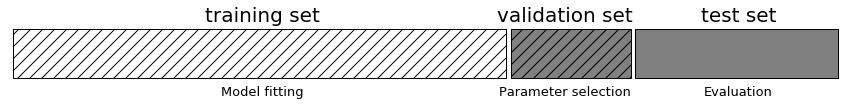

In [16]:
mglearn.plots.plot_threefold_split()
plt.show()

In [18]:
from sklearn.svm import SVC
# データを訓練+検証セットとテストセットに分割する
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
# 訓練+検証セットを訓練セットと検証セットに分割する
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)
print("Size of training set: {}   size of validation set: {}   size of test set:"" {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        score = svm.score(X_valid, y_valid)

        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84   size of validation set: 28   size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


### 交差検証を用いたグリッドサーチ

上の方法はよく使われるが、データの分割され方によって性能が左右する。汎化性能をよりよく見積もるには、学習データと検証データの分割を１度行うのではなく、それぞれのパラメータの組み合わせに対して交差検証すれば良い。

In [21]:
from sklearn.model_selection import cross_val_score
import numpy as np

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        score = np.mean(scores)

        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

この処理は少し時間がかかる

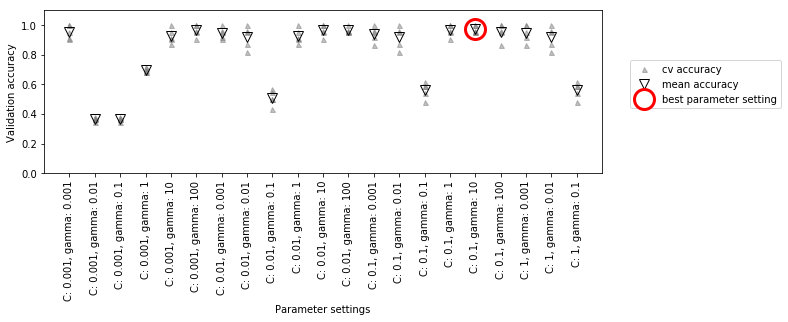

In [22]:
mglearn.plots.plot_cross_val_selection()
plt.show()

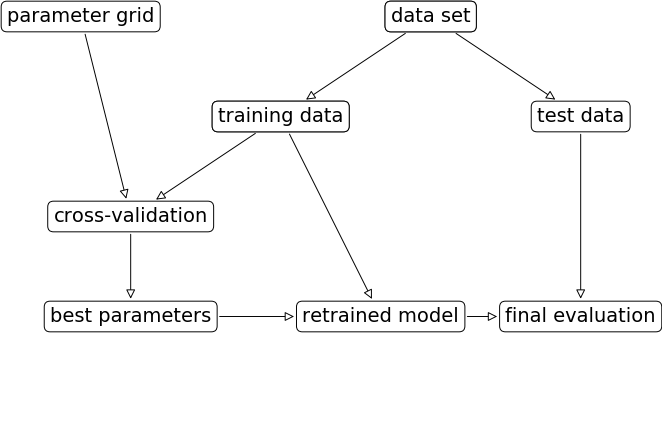

In [23]:
mglearn.plots.plot_grid_search_overview()
plt.show()

In [24]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

In [27]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

scoreはテストデータに対する評価。best_score_は学習データでの交差検証の平均交差検証精度。

In [28]:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.97


In [29]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'gamma': 0.01}
Best cross-validation score: 0.97


In [30]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


### 交差検証の結果の解析

交差検証の結果を可視化すると、モデルの汎化性能がサーチパラメータに依存する様子を理解するのに役立つ。グリッドサーチは計算時間がかかるので、荒く始める。

grid_searchには特定のパラメータの組み合わせ、全ての交差検証での分割、平均、標準偏差が記録されている。２次元（gamma、C）のパラメータグリッドを探索しているのでヒートマップ可視化する。

In [31]:
import pandas as pd

results = pd.DataFrame(grid_search.cv_results_)
results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.001266,0.000504,0.366071,0.366079,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",22,0.375,0.363636,...,0.363636,0.366667,0.363636,0.366667,0.380952,0.362637,0.000275,0.000091,0.011371,0.002852
1,0.001374,0.000643,0.366071,0.366079,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",22,0.375,0.363636,...,0.363636,0.366667,0.363636,0.366667,0.380952,0.362637,0.000424,0.000138,0.011371,0.002852
2,0.001156,0.000553,0.366071,0.366079,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",22,0.375,0.363636,...,0.363636,0.366667,0.363636,0.366667,0.380952,0.362637,0.000221,0.000253,0.011371,0.002852
3,0.000651,0.000257,0.366071,0.366079,0.001,1,"{'C': 0.001, 'gamma': 1}",22,0.375,0.363636,...,0.363636,0.366667,0.363636,0.366667,0.380952,0.362637,0.000009,0.000003,0.011371,0.002852
4,0.000696,0.000271,0.366071,0.366079,0.001,10,"{'C': 0.001, 'gamma': 10}",22,0.375,0.363636,...,0.363636,0.366667,0.363636,0.366667,0.380952,0.362637,0.000095,0.000038,0.011371,0.002852


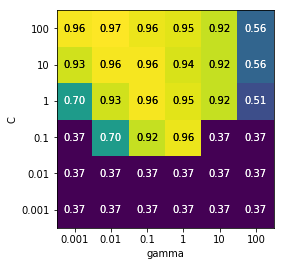

In [33]:
scores = np.array(results.mean_test_score).reshape(6, 6)

mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'], cmap="viridis")
plt.show()

SVCは非常にパラメータに敏感であることがわかる。

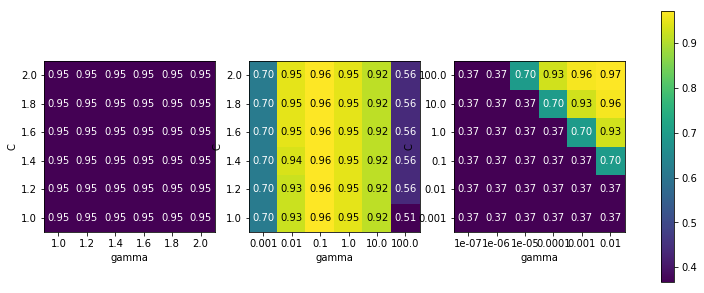

In [35]:
# 不適切なサーチグリット
fig, axes = plt.subplots(1, 3, figsize=(13, 5))

param_grid_linear = {'C': np.linspace(1, 2, 6),
                     'gamma':  np.linspace(1, 2, 6)}

param_grid_one_log = {'C': np.linspace(1, 2, 6),
                      'gamma':  np.logspace(-3, 2, 6)}

param_grid_range = {'C': np.logspace(-3, 2, 6),
                    'gamma':  np.logspace(-7, -2, 6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log,
                           param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)

    scores_image = mglearn.tools.heatmap(
        scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'],
        yticklabels=param_grid['C'], cmap="viridis", ax=ax)

plt.colorbar(scores_image, ax=axes.tolist())
plt.show()

最初のパネルには変化がない。Cとgammaの大きさとレンジが不適切。2番目は変化はしているがストライプになっている。gammaだけ精度に影響している。gammaのみ良いサーチをしており、Cはそうではない。Cが重要でないということもあり得る。3番目は左下は変化がない。レンジを調整すべき。

### グリッドでないサーチ空間

適さない場合がある。例えばSVCにはkernelというパラメータがあり、カーネルにより他のパラメータが決まる。kernel=linearであれば線形にりパラメータがCのみになる。kernel=rbfの場合はCとgammaが使われる。linearの場合はgammaが使われないので<b>条件付き</b>パラメータを使うために param_gridとしてディク書なりのリストを受け付けれる。

In [36]:
param_grid = [
    {'kernel': ['rbf'],
     'C': [0.001, 0.01, 0.1, 1, 10, 100],
     'gamma': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    {'kernel': ['linear'],
       'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }
]
print("List of grids:\n{}".format(param_grid))

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In [37]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.97


In [39]:
results = pd.DataFrame(grid_search.cv_results_)

results.T

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.00124078,0.0010973,0.00105844,0.00113649,0.000882387,0.000837898,0.000778198,0.000731802,0.000804567,0.000751543,...,0.000354481,0.000532436,0.000751829,0.000956821,0.000590706,0.00062952,0.000516748,0.000468826,0.000373554,0.000408411
mean_score_time,0.000557137,0.000532389,0.000500488,0.000531292,0.000349855,0.000365257,0.0004282,0.000280285,0.000285435,0.000273705,...,0.000193501,0.000226927,0.000235653,0.000275803,0.000250959,0.000317383,0.000317669,0.000264311,0.000229931,0.000195169
mean_test_score,0.366071,0.366071,0.366071,0.366071,0.366071,0.366071,0.366071,0.366071,0.366071,0.366071,...,0.955357,0.946429,0.919643,0.5625,0.366071,0.848214,0.946429,0.973214,0.964286,0.964286
mean_train_score,0.366079,0.366079,0.366079,0.366079,0.366079,0.366079,0.366079,0.366079,0.366079,0.366079,...,0.988788,1,1,1,0.366079,0.855069,0.966538,0.984368,0.988813,0.993258
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
rank_test_score,27,27,27,27,27,27,27,27,27,27,...,9,11,17,24,27,21,11,1,3,3
split0_test_score,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,...,0.958333,0.916667,0.875,0.541667,0.375,0.916667,0.958333,1,0.958333,0.958333


### 異なる交差検証手法を用いたグリッドサーチ

GridSearchCVはcross_val_scoreと同様にデフォルトではクラス分類に層化k分割交差検証を、回帰にはk分割交差検証を用いる。しかし他の方法として学習データとテストデータへの分割を1回にするにはShuffleSplitあるいはStratifiedShuffleSplitを用いてn_iter=1とする。データセットが大きい場合や、モデルの計算に時間がかかる時に有用。

### ネストした交差検証

GridSearchCVを用いると，データを訓練セットとテストセットに一度だけ分ける．その為，データの一度だけの分割に結果が依存してしまう．
その為，元のデータを一度だけ訓練セットとテストセットに分けるのではなく，交差検証で何度も分割する．この手法を`ネストした交差検証`と呼ぶ．

ネストした交差検証では，外側にループを設け，そこでデータを訓練セットとテストセットに分割し，外側ループのそれぞれの分割に対して最良のパラメータを見つけ，最良のセッティングでテストセットを評価する．

cross_val_scoreで簡単に書ける。

In [40]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),iris.data, iris.target, cv=5)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [ 0.96666667  1.          0.96666667  0.96666667  1.        ]
Mean cross-validation score:  0.98


cross_val_scoreで何が起こってるのかを書いてくれてる。


In [41]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []

    for training_samples, test_samples in outer_cv.split(X, y):

        best_parms = {}
        best_score = -np.inf

        for parameters in parameter_grid:

            cv_scores = []

            for inner_train, inner_test in inner_cv.split(X[training_samples], y[training_samples]):
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])

                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)

            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = parameters

        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])

        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    return np.array(outer_scores)

In [42]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold

scores = nested_cv(iris.data, iris.target, StratifiedKFold(5),StratifiedKFold(5), SVC, ParameterGrid(param_grid))
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [ 0.96666667  1.          0.96666667  0.96666667  1.        ]


### 交差検証とグリッドサーチの並列化

大規模データで並列化したければspark-sklearnなど使おう。